# Mask, center, correct, calibrate and threshold 2D raw data

In [1]:
import hyperspy.api as hs
import pyxem as pxm
import os, glob, gc
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tqdm
%matplotlib widget
import json
import py4DSTEM
import logging
hs.__version__, pxm.__version__, py4DSTEM.__version__

('1.7.3', '0.14.2', '0.13.6')

In [2]:
DATA_ROOT = r"G:\My Drive\PhD\projects\sed_ML\clustering_poyen\data\experimental"

data_files = []

# Name of files
data_wildcard = '**/*_data.hdf5'
metadata_wildcard = '*.hdf'

apply_mask = True
mask_fname = r'**/mask.npy'

threshold_ones = False
rotate_dp = False

crop_nav = False
crop_sig = False

global_cal_json_path = 'calibrations_diff.json'
rotation_angle = 76.75

In [3]:
data_files = glob.glob(os.path.join(DATA_ROOT, data_wildcard), recursive=True)
data_files.sort()

print(len(data_files))
data_files[:], len(data_files)

4


(['G:\\My Drive\\PhD\\projects\\sed_ML\\clustering_poyen\\data\\experimental\\dcdh_20220628_114631\\20220628_114631_data.hdf5',
  'G:\\My Drive\\PhD\\projects\\sed_ML\\clustering_poyen\\data\\experimental\\polytype_all_20220720_155557\\20220720_155557_data.hdf5',
  'G:\\My Drive\\PhD\\projects\\sed_ML\\clustering_poyen\\data\\experimental\\tcdh_thin_20211117_182521\\20211117_182521_data.hdf5',
  'G:\\My Drive\\PhD\\projects\\sed_ML\\clustering_poyen\\data\\experimental\\tcdh_thin_20211117_182814\\20211117_182814_data.hdf5'],
 4)

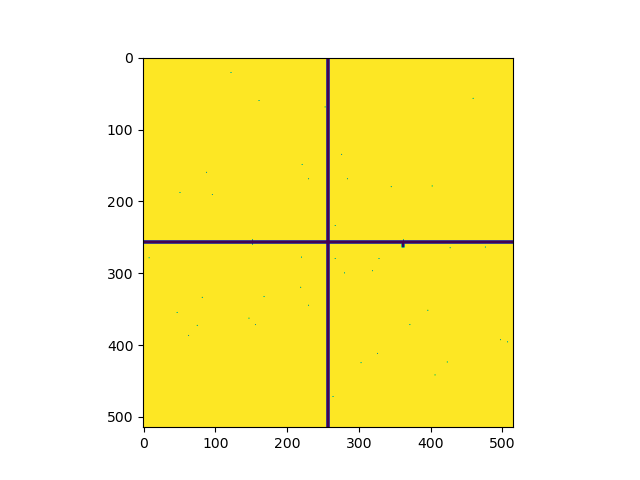

In [4]:
# Load a mask to cover the dead pixels and the joints between detectors
mask_fname = glob.glob(os.path.join(DATA_ROOT, mask_fname), recursive=True)[0]
mask = np.load(mask_fname)
plt.imshow(mask)

In [5]:
def get_magnification_from_file(metadata_fname):
    md = h5py.File(metadata_fname, 'r')
    mag = np.array(md['metadata/magnification'])
    return mag


# This can be removed once py4DSTEM gets updated in env
import numpy as np
from py4DSTEM.process.utils import get_CoM
def get_probe_size(DP, thresh_lower=0.01, thresh_upper=0.99, N=100):
    """
    Gets the center and radius of the probe in the diffraction plane.
    The algorithm is as follows:
    First, create a series of N binary masks, by thresholding the diffraction pattern
    DP with a linspace of N thresholds from thresh_lower to thresh_upper, measured
    relative to the maximum intensity in DP.
    Using the area of each binary mask, calculate the radius r of a circular probe.
    Because the central disk is typically very intense relative to the rest of the DP, r
    should change very little over a wide range of intermediate values of the threshold.
    The range in which r is trustworthy is found by taking the derivative of r(thresh)
    and finding identifying where it is small.  The radius is taken to be the mean of
    these r values. Using the threshold corresponding to this r, a mask is created and
    the CoM of the DP times this mask it taken.  This is taken to be the origin x0,y0.
    Args:
        DP (2D array): the diffraction pattern in which to find the central disk.
            A position averaged, or shift-corrected and averaged, DP works best.
        thresh_lower (float, 0 to 1): the lower limit of threshold values
        thresh_upper (float, 0 to 1): the upper limit of threshold values
        N (int): the number of thresholds / masks to use
    Returns:
        (3-tuple): A 3-tuple containing:
            * **r**: *(float)* the central disk radius, in pixels
            * **x0**: *(float)* the x position of the central disk center
            * **y0**: *(float)* the y position of the central disk center
    """
    thresh_vals = np.linspace(thresh_lower, thresh_upper, N)
    r_vals = np.zeros(N)

    # Get r for each mask
    DPmax = np.max(DP)
    for i in range(len(thresh_vals)):
        thresh = thresh_vals[i]
        mask = DP > DPmax * thresh
        r_vals[i] = np.sqrt(np.sum(mask) / np.pi)

    # Get derivative and determine trustworthy r-values
    dr_dtheta = np.gradient(r_vals)
    mask = (dr_dtheta <= 0) * (dr_dtheta >= 2 * np.median(dr_dtheta))
    r = np.mean(r_vals[mask])

    # Get origin
    thresh = np.mean(thresh_vals[mask])
    mask = DP > DPmax * thresh
    x0, y0 = get_CoM(DP * mask)
    
    return r, x0, y0

def find_origin_using_cropped_signal(data, rad, x0, y0, crop_window_size = 0.005):
    '''
    Args:
        data (DataCube instance): 4D-STEM dataset for which the origins will be found
        rad (float): approximate radius of the central beam
        x0 (float): approximate x coordinate of the central beam
        y0 (float): approximate y coordinate of the central beam
        crop_window_size (float, 0 to 1) proportion of the diffraction plane to use as a search window around the approximate centre
    Returns:
        (np.array): 
            A numpy array of shape (2, Rx,Ry) containing the central coordinates at each real space location
    '''    
    
    #get a search window around the approximate centre based on a proportion of the total diffraction imaging plane
    central_search_width = int(np.ceil(rad + data.data.shape[2]*crop_window_size))
    
    #calculate the bounds of this search window
    x0r, y0r = int(x0//1), int(y0//1)
    x_lower, x_upper =  x0r-central_search_width, x0r+central_search_width
    y_lower, y_upper =  y0r-central_search_width, y0r+central_search_width
    
    #create a cropped DataCube instance
    d_cent = py4DSTEM.io.DataCube(data.data[:,:,x_lower:x_upper,y_lower:y_upper])

    #Find the origin of these cropped patterns
    origins = py4DSTEM.process.calibration.origin.get_origin(d_cent, r = rad, rscale = 1.1) 
    cent_coords = list(origins)
    cent_coords = np.asarray(cent_coords)
    cent_coords = cent_coords[:2,:,:]
    
    #translate these central coordinates to uncropped image 
    cent_coords += np.array((x_lower, y_lower))[:,None,None]
    
    return cent_coords


def center_using_pyxem(dp, mask):
    
    mean_dp = dp.mean()
    # Get mean diffraction pattern to centre from there
    mean_dp *= mask

    centre = mean_dp.get_direct_beam_position(method = 'cross_correlate', radius_start = 1, radius_finish = 10)
    shifts = [[centre.data[1], centre.data[0]]]
    mean_dp.change_dtype('float32')
    # Create shifts array and align and centre
    n_shifts = shifts*(len(dp.data[0])*len(dp.data[:,1]))
    n_shifts=np.array(n_shifts)
    n_shifts = n_shifts.reshape(dp.data.shape[0],dp.data.shape[1],2)
    dp.align2D(shifts = -n_shifts, crop = False)
    dp.center_direct_beam(method='interpolate', sigma=5, upsample_factor=4, kind='linear', half_square_width=10)
    return dp, shifts

In [7]:
for i, fname in tqdm.tqdm_notebook(enumerate(data_files[2:3])):
    
    dp_dir = os.path.dirname(fname)
    dp_name = os.path.basename(fname).split('.')[0]
    #dp_name = dp_name.replace('_data_data', '')
    print(dp_name)

    # # Check if file already processed
    name_temp = f'{dp_name}_calibrated_data.hspy'
    path_to_check = os.path.join(dp_dir, name_temp)
    if os.path.exists(path_to_check):
        print(f"{dp_name} already processed!")
        continue

    # Load file
    f = h5py.File(fname, 'r')['Experiments/__unnamed__/data']
    dp = pxm.signals.electron_diffraction2d.ElectronDiffraction2D(np.array(f))

    # Apply mask
    if apply_mask:
        dp *= mask

    # Crop dp into divisible shape
    if crop_nav:
        dp = dp.inav[1:,1:]
    if crop_sig:
        dp = dp.isig[:-1,:-1]

    # Reset the offset
    dp.axes_manager.navigation_axes[0].offset = 0
    dp.axes_manager.navigation_axes[1].offset = 0
    dp.axes_manager.signal_axes[0].offset = 0
    dp.axes_manager.signal_axes[1].offset = 0

    # shift function
    logging.info("Aligning the BF disc in the data.")
    d_before = dp.mean()
    from scipy import ndimage
    def shift_image(im, shift=0, interpolation_order=1, fill_value=0):
        if not np.any(shift):
            return im
        else:
            fractional, integral = np.modf(shift)
            if fractional.any():
                order = interpolation_order
            else:
                # Disable interpolation
                order = 0
            return ndimage.shift(im, shift, cval=fill_value, order=order)
    # Getting the origin coordinates
    data = py4DSTEM.io.DataCube(dp.data)
    
    # find good value for r for arbitrary data
    rad, x0, y0 = get_probe_size(data.data[0,0,:,:])
    print('BF disc radius in pixels:', int(rad))
    ## Hard coded this in as was sometimes getting confused
    # x0 = 297
    # y0 = 224
    
    # Here rad is radius of BF disc
    cent_coords = find_origin_using_cropped_signal(data, rad, x0, y0)
    
    # expressing them as shift values
    cent_coords = cent_coords.reshape(2, dp.data.shape[0]*dp.data.shape[1])
    shifts = -1 * (cent_coords - 515 // 2)
    
#     # Apply the above shifts
#     data_resh = np.reshape(data.data, (d.data.shape[0]*d.data.shape[1],515,515))
#     for i in range(data_resh.shape[0]):
#         data_resh[i,:,:] = shift_image(data_resh[i,:,:], shift= [shifts[0][i], shifts[1][i]])
        
    
    dp, shifts = center_using_pyxem(dp, mask)
    d_mean = dp.mean()    
        
    #Plotting mean signal with the estimate of the centre positions
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(np.log10(1 + d_before.data), vmax=0.4)
    axs[0].set_title('before align')
    axs[1].imshow(np.log10(1 + d_mean.data), vmax=0.4)
    axs[1].set_title('after align')
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(f'{os.getcwd()}/aligning_BF_disc.png')

    # Calibrate
    # Check to see if json file with diff cals existing
    def load_calibrations(global_cal_json_path, dp_dir):
        import json
        with open(os.path.join(dp_dir, global_cal_json_path)) as json_file:
            cals = json.load(json_file)

        recip_pix = cals['reciprocal_space_pix(1/A)']
        affine_matrix = np.asarray(cals['affine_transform'])
        nav_cal = cals['real_space_pix(nm)']
        return recip_pix, affine_matrix, nav_cal

    recip_pix, affine_matrix, nav_cal = load_calibrations(global_cal_json_path, dp_dir)
    dp.set_scan_calibration(nav_cal)
    dp.set_diffraction_calibration(recip_pix)

    dp.apply_affine_transformation(affine_matrix,keep_dtype=True)
    dp_mean = dp.mean()
    rad, x0, y0 = get_probe_size(dp_mean.data)
    print(f'estimate of BF rad: {rad} and position {x0}, {y0}')
    dp.set_diffraction_calibration(recip_pix, center=(recip_pix * x0,recip_pix * y0))
    
    # saving a calibrated version
    dp.save(f'{dp_dir}/{dp_name}_calibrated_data', overwrite=True)
    dp.save(f'{dp_dir}/{dp_name}_calibrated_data', overwrite=True)










    # # Get mean diffraction pattern to centre from there
    # mean_dp = dp.mean()
    # mean_dp = pxm.signals.electron_diffraction2d.ElectronDiffraction2D(mean_dp)
    # centre = mean_dp.get_direct_beam_position(method = 'cross_correlate', radius_start = 1, radius_finish = 10)
    # shifts = [[centre.data[0], centre.data[1]]]

    # # Create shifts array and align and centre
    # n_shifts = shifts * dp.axes_manager.navigation_shape[0] * dp.axes_manager.navigation_shape[1]
    # n_shifts=np.array(n_shifts)
    # new_shape = (dp.axes_manager.navigation_shape[1], dp.axes_manager.navigation_shape[0], 2)
    # n_shifts = n_shifts.reshape(new_shape)
    # dp.align2D(shifts = -n_shifts, crop = False)
    # dp.center_direct_beam(method='interpolate', sigma=5, upsample_factor=4, kind='linear', half_square_width=10)

    

    # # Save cropped
    # # name_temp = f'{dp_name}_cropped.hspy'
    # # dp.save(os.path.join(dp_dir, name_temp), overwrite=True)

    # # Apply affine transforms (affine + rot)
    # transform_mat = affine_matrix
    # dp.apply_affine_transformation(transform_mat, keep_dtype=True)

    # # Rotate
    # if rotate_dp:
    #     continue
    #     # TODO: Add scipy.rotate with the dp.map function

    # dp.set_diffraction_calibration(recip_pix)
    # # Save
    # name_temp = f'{dp_name}_processed.hspy'
    # dp.save(os.path.join(dp_dir, name_temp), overwrite=True)

    # # Save sum_dp
    # sum_dp = dp.sum()
    # name_temp = f'{dp_name}_sum_dp.hspy'
    # sum_dp.save(os.path.join(dp_dir, name_temp), overwrite=True)
    # sum_dp.change_dtype('float32')
    # name_temp = f'{dp_name}_sum_dp.tiff'
    # sum_dp.save(os.path.join(dp_dir, name_temp), overwrite=True)

    # # Save rebinned data
    # dp_nav_rebin = dp.inav[:-1,:-1].rebin(scale=[2,2,1,1])
    # name_temp = f'{dp_name}_rebin_nav_2.hspy'
    # dp_nav_rebin.save(os.path.join(dp_dir, name_temp), overwrite=True)

    # dp_sig_rebin = dp.isig[:-1,:-1].rebin(scale=[1,1,2,2])
    # name_temp = f'{dp_name}_rebin_sig_2.hspy'
    # dp_sig_rebin.save(os.path.join(dp_dir, name_temp), overwrite=True)

    # if threshold_ones:
    #     # Threshold the pixels with counts 1
    #     dp2 = dp.deecopy()
    #     dp2.data[dp2.data==1] = 0
    #     name_temp = f'{dp_name}_processed_threshold.hspy'
    #     dp2.save(os.path.join(dp_dir, name_temp), overwrite=True)
    #     del dp2

    # Clean up memory
    del dp
    gc.collect()
    print(f"File {i} {dp_name} finished.")

C:\Users\jf631\AppData\Local\Temp\ipykernel_8220\4077544651.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, fname in tqdm.tqdm_notebook(enumerate(data_files[2:3])):


0it [00:00, ?it/s]

[########################################] | 100% Completed | 130.69 s
estimate of BF rad: 5.217239678505429 and position 256.0480941472494, 252.53883805463568
File 0 20211117_182521_data finished.


In [7]:
# name_temp = f'{dp_name}_processed.hspy'
# dp = hs.load(os.path.join(dp_dir, name_temp),)
# print(dp)

In [8]:
x0

255.97447023712897